In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [4]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [10]:
window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [12]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 39ms/step - loss: 73.1912 - mae: 73.6903 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 35ms/step - loss: 72.4799 - mae: 72.9791 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 71.3446 - mae: 71.8437 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 69.9230 - mae: 70.4223 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 68.2678 - mae: 68.7669 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 32ms/step - loss: 66.3621 - mae: 66.8609 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 64.2432 - mae: 64.7424 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 34ms/step - loss: 61.8749 - mae: 62.3738 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 35ms/step - loss: 59.2491 - mae: 59.7479 - lr: 2.5

8/8 [==============================] - 0s 29ms/step - loss: 7.0451 - mae: 7.5324 - lr: 4.4668e-05
Epoch 75/100
8/8 [==============================] - 0s 28ms/step - loss: 9.0403 - mae: 9.5292 - lr: 5.0119e-05
Epoch 76/100
8/8 [==============================] - 0s 29ms/step - loss: 29.9137 - mae: 30.4118 - lr: 5.6234e-05
Epoch 77/100
8/8 [==============================] - 0s 29ms/step - loss: 25.7370 - mae: 26.2334 - lr: 6.3096e-05
Epoch 78/100
8/8 [==============================] - 0s 32ms/step - loss: 24.5063 - mae: 25.0036 - lr: 7.0795e-05
Epoch 79/100
8/8 [==============================] - 0s 29ms/step - loss: 14.3830 - mae: 14.8767 - lr: 7.9433e-05
Epoch 80/100
8/8 [==============================] - 0s 29ms/step - loss: 14.6587 - mae: 15.1529 - lr: 8.9125e-05
Epoch 81/100
8/8 [==============================] - 0s 28ms/step - loss: 16.4291 - mae: 16.9233 - lr: 1.0000e-04
Epoch 82/100
8/8 [==============================] - 0s 29ms/step - loss: 20.0425 - mae: 20.5375 - lr: 1.1220e-04


(1e-08, 0.0001, 0.0, 30.0)

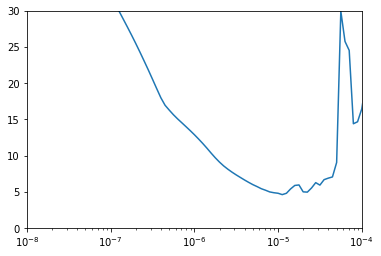

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [19]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

In [20]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [21]:
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 1s 20ms/step - loss: 20.0714 - mae: 20.5646
Epoch 2/500
31/31 [==============================] - 1s 20ms/step - loss: 7.9198 - mae: 8.4048
Epoch 3/500
31/31 [==============================] - 1s 19ms/step - loss: 6.6716 - mae: 7.1533
Epoch 4/500
31/31 [==============================] - 1s 20ms/step - loss: 6.1672 - mae: 6.6476
Epoch 5/500
31/31 [==============================] - 1s 20ms/step - loss: 5.7151 - mae: 6.1946
Epoch 6/500
31/31 [==============================] - 1s 18ms/step - loss: 5.6375 - mae: 6.1175
Epoch 7/500
31/31 [==============================] - 1s 19ms/step - loss: 5.4287 - mae: 5.9080
Epoch 8/500
31/31 [==============================] - 1s 18ms/step - loss: 5.3714 - mae: 5.8510
Epoch 9/500
31/31 [==============================] - 1s 19ms/step - loss: 5.3567 - mae: 5.8367
Epoch 10/500
31/31 [==============================] - 1s 19ms/step - loss: 5.2224 - mae: 5.7017
Epoch 11/500
31/31 [===========================

31/31 [==============================] - 1s 19ms/step - loss: 4.2689 - mae: 4.7436
Epoch 87/500
31/31 [==============================] - 1s 18ms/step - loss: 4.2935 - mae: 4.7690
Epoch 88/500
31/31 [==============================] - 1s 19ms/step - loss: 4.2199 - mae: 4.6940
Epoch 89/500
31/31 [==============================] - 1s 19ms/step - loss: 4.2216 - mae: 4.6962
Epoch 90/500
31/31 [==============================] - 1s 19ms/step - loss: 4.2337 - mae: 4.7081
Epoch 91/500
31/31 [==============================] - 1s 18ms/step - loss: 4.2411 - mae: 4.7153
Epoch 92/500
31/31 [==============================] - 1s 18ms/step - loss: 4.2446 - mae: 4.7197
Epoch 93/500
31/31 [==============================] - 1s 18ms/step - loss: 4.2180 - mae: 4.6921
Epoch 94/500
31/31 [==============================] - 1s 19ms/step - loss: 4.3016 - mae: 4.7757
Epoch 95/500
31/31 [==============================] - 1s 18ms/step - loss: 4.2827 - mae: 4.7574
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 1s 18ms/step - loss: 4.2536 - mae: 4.7282
Epoch 171/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0995 - mae: 4.5725
Epoch 172/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1431 - mae: 4.6168
Epoch 173/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1119 - mae: 4.5850
Epoch 174/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1143 - mae: 4.5875
Epoch 175/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1461 - mae: 4.6206
Epoch 176/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1041 - mae: 4.5765
Epoch 177/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1105 - mae: 4.5838
Epoch 178/500
31/31 [==============================] - 1s 19ms/step - loss: 4.1305 - mae: 4.6046
Epoch 179/500
31/31 [==============================] - 1s 18ms/step - loss: 4.2719 - mae: 4.7476
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 1s 18ms/step - loss: 4.0336 - mae: 4.5064
Epoch 255/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1287 - mae: 4.6030
Epoch 256/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1186 - mae: 4.5920
Epoch 257/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1169 - mae: 4.5912
Epoch 258/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0547 - mae: 4.5274
Epoch 259/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0447 - mae: 4.5181
Epoch 260/500
31/31 [==============================] - 1s 17ms/step - loss: 4.0944 - mae: 4.5672
Epoch 261/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1504 - mae: 4.6244
Epoch 262/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0844 - mae: 4.5584
Epoch 263/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0862 - mae: 4.5599
Epoch 264/500
31/31 [=======================

31/31 [==============================] - 1s 18ms/step - loss: 3.9831 - mae: 4.4555
Epoch 339/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9620 - mae: 4.4338
Epoch 340/500
31/31 [==============================] - 1s 19ms/step - loss: 4.0356 - mae: 4.5085
Epoch 341/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0373 - mae: 4.5115
Epoch 342/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0081 - mae: 4.4808
Epoch 343/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9821 - mae: 4.4545
Epoch 344/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0140 - mae: 4.4874
Epoch 345/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0050 - mae: 4.4784
Epoch 346/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9723 - mae: 4.4440
Epoch 347/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9965 - mae: 4.4684
Epoch 348/500
31/31 [=======================

31/31 [==============================] - 1s 18ms/step - loss: 3.9316 - mae: 4.4036
Epoch 423/500
31/31 [==============================] - 1s 19ms/step - loss: 3.9280 - mae: 4.3989
Epoch 424/500
31/31 [==============================] - 1s 19ms/step - loss: 3.9345 - mae: 4.4063
Epoch 425/500
31/31 [==============================] - 1s 20ms/step - loss: 3.9537 - mae: 4.4261
Epoch 426/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9464 - mae: 4.4185
Epoch 427/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9840 - mae: 4.4569
Epoch 428/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9608 - mae: 4.4332
Epoch 429/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9362 - mae: 4.4077
Epoch 430/500
31/31 [==============================] - 1s 19ms/step - loss: 4.0077 - mae: 4.4799
Epoch 431/500
31/31 [==============================] - 1s 19ms/step - loss: 3.9385 - mae: 4.4105
Epoch 432/500
31/31 [=======================

In [22]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

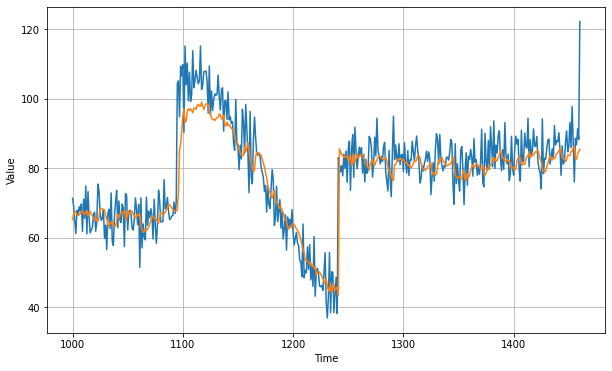

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0940313

<Figure size 432x288 with 0 Axes>

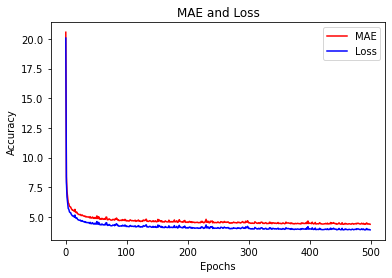

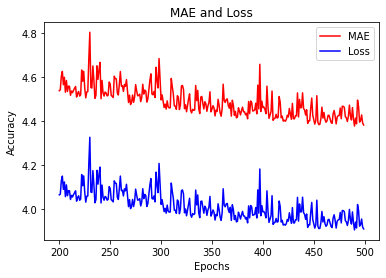

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()